# Real Estate Demand Prediction: Explained baseline

This notebook shows a baseline model for the competition and its cross-validation.

Reference:
- [Kaggle competition](https://www.kaggle.com/competitions/china-real-estate-demand-prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Style

from sklearn.model_selection import TimeSeriesSplit


In [2]:
def custom_score(y_true, y_pred, eps=1e-12):
    """Scoring function of the competition as defined on the competition overview page.
    
    Parameters:
    -----------
    y_true : array-like
    y_pred : array-like
    eps : float, optional (exact value doesn't matter)

    Return value:
    -------------
    dict with keys 'score', 'good_rate' and 'str'
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    if y_true.size == 0:
        raise ValueError('empty array')

    if (y_true < 0).any():
        raise ValueError('negative y_true')

    if (~ np.isfinite(y_pred)).any():
        raise ValueError('infinite y_pred')

    ape = np.abs((y_true - y_pred) / np.maximum(y_true, eps))

    good_mask = ape <= 1.0
    good_rate = good_mask.mean()
    if good_rate < 0.7:
        return {'score': 0, 'good_rate': good_rate, 'str': f"{Fore.RED}score={0:.3f} {good_rate=:.3f}{Style.RESET_ALL}"}

    good_ape = ape[good_mask]
    mape = np.mean(good_ape)

    scaled_mape = mape / good_rate
    score = 1 - scaled_mape
    # score = max(0.0, score)
    return {'score': score, 'good_rate': good_rate, 'str': f"{score=:.3f} {good_rate=:.3f}"}

In [3]:
# We read all the data although this baseline notebook ignores most of it
# We convert the string-encoded months to integer values (time is 0..66 for train and 67..78 for test)

ci = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/city_indexes.csv') # one row per year
csi = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/city_search_index.csv') # several rows per training month
sp = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/sector_POI.csv') # at most one row per sector

train_lt = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/land_transactions.csv')
train_ltns = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/land_transactions_nearby_sectors.csv')
train_pht = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/pre_owned_house_transactions.csv')
train_phtns = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/pre_owned_house_transactions_nearby_sectors.csv')
train_nht = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/new_house_transactions.csv')
train_nhtns = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/new_house_transactions_nearby_sectors.csv')
test = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/test.csv')

month_codes = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

test_id = test.id.str.split('_', expand=True)
test['month'] = test_id[0]
test['sector'] = test_id[1]
del test_id

for df in [train_lt, train_ltns, train_pht, train_phtns, train_nht, train_nhtns, csi, sp, test]:
    if df is not csi:
        df['sector_id'] = df.sector.str.slice(7, None).astype(int)
        # print(df.sector_id.min(), df.sector_id.max(), len(np.unique(df.sector_id)), len(df))
    if df is not sp:
        df['year'] = df.month.str.slice(0, 4).astype(int)
        df['month'] = df.month.str.slice(5, None).map(month_codes)
        df['time'] = (df['year'] - 2019) * 12 + df['month'] - 1 # min=0, max=66
        print(df['time'].min(), df['time'].max())


0 66
0 66
0 66
0 66
0 66
0 66
0 66
67 78


# Initial observations

1. This is a time series competition: The training dataset comprises Jan 2019 through Jul 2024 (67 months). The test period is Aug 2024 through Jul 2025 (12 months).

2. The prediction target is `amount_new_house_transactions` in `train/new_house_transactions.csv`.

3. The data are organized into 96 sectors. The sectors have widely varying sizes and different missing value patterns. Sector 95 has no new house transations during the training period.

4. The test dataframe is the cartesian product of the 96 sectors and the 12 test months. This means that we must predict `amount_new_house_transactions` for all 96 sectors and all 12 test months. In other words: **We have to extrapolate 96 time series for 12 time steps each.**

We now extract the target variable `amount_new_house_transactions` into a 2d array. Every column of the array is a time series, and the competition tasks basically consists of extrapolating to the next 12 rows of this array:

In [4]:
amount_new_house_transactions = train_nht.set_index(['time', 'sector_id']).amount_new_house_transactions.unstack()
# Missing values must be filled with zero:
amount_new_house_transactions = amount_new_house_transactions.fillna(0)
# We add sector 95, which has no transactions during the training period:
amount_new_house_transactions[95] = 0
amount_new_house_transactions = amount_new_house_transactions[np.arange(1, 97)]
amount_new_house_transactions.astype(int)

sector_id,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
time,,,,,,,,,,,,,,,,,,,,,
0,13827,28277,0,1424,792,607,39326,10454,4170,11043,...,0,37312,9676,1795,14989,26427,16539,70238,0,0
1,8802,12868,0,1522,409,603,13707,3015,1318,9916,...,0,14923,5709,0,4185,15702,12333,43823,0,0
2,23283,18694,0,1779,833,1024,16279,3602,30631,10852,...,263,57859,25247,0,9404,28988,26310,116638,0,809
3,26626,15460,0,663,0,3471,17472,6238,27396,3387,...,0,17610,14016,0,6764,37055,34804,146907,0,535
4,8649,20565,0,1387,0,4863,12227,3597,10354,3140,...,0,18462,4510,2279,7866,37666,52138,108483,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,4605,7552,15716,71227,1847,12306,7058,7474,44942,44429,...,0,4187,3559,9023,29480,38262,13316,21061,0,0
63,3622,3155,3248,64991,2712,19563,5948,6278,10381,52813,...,0,3111,2304,9620,11058,28710,13961,18301,0,0
64,4229,3833,1013,71032,500,17662,5503,2653,6260,54442,...,0,3594,0,7302,19585,28258,15912,18053,0,0


A diagram of the total amounts (summed over all 96 sectors) shows that the time series has no obvious trend, but distinctive peaks every December:

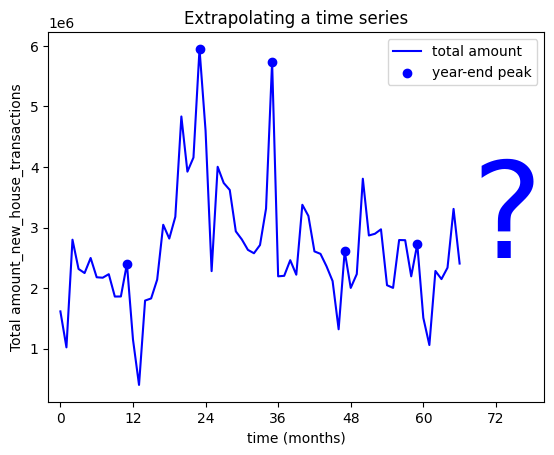

In [5]:
plt.title('Extrapolating a time series')
plt.plot(amount_new_house_transactions.sum(axis=1),
         color='b',
         label='total amount'
        )
plt.scatter(np.arange(11, 67, 12),
            amount_new_house_transactions.sum(axis=1).iloc[np.arange(11, 67, 12)],
            color='b',
            label='year-end peak')
plt.text(68, 2500000, '?', fontsize=96, color='b')
plt.xticks(np.arange(0, 80, 12))
plt.xlim(-2, 80)
plt.xlabel('time (months)')
plt.ylabel('Total amount_new_house_transactions')
plt.legend()
plt.show()

# Baseline prediction

Our baseline model works as follows:

1. If in the last six months of the training data for a sector there is any month with a zero amount, we predict zero. Otherwise there would be a high risk that y_true is zero, y_pred is nonzero, and the contribution to the MAPE would be huge.
2. If the last six months all had nonzero amounts, we predict the gemoetric mean of the last six training months for the whole test period.
3. For the moment, we ignore the yearly seasonality.
4. ... and we ignore all other features of the dataset.

To cross-validate the model, we use a `TimeSeriesSplit`:

In [6]:
t1 = 6 # months for geometric mean
t2 = 6 # months which must be nonzero
cv = TimeSeriesSplit(n_splits=4, test_size=12)
true, oof = [], []
for fold, (idx_tr, idx_va) in enumerate(cv.split(amount_new_house_transactions)):
    print(f"# Fold {fold}: train on months {idx_tr.min()}..{idx_tr.max()}, validate on months {idx_va.min()}..{idx_va.max()}")
    a_tr = amount_new_house_transactions.iloc[idx_tr]
    a_va = amount_new_house_transactions.iloc[idx_va]

    a_pred = pd.DataFrame(
        {time: np.exp(np.log(a_tr.tail(t1)).mean(axis=0)) for time in idx_va}
    ).T
    a_pred.loc[:, a_tr.tail(t2).min(axis=0) == 0] = 0
    a_pred.index.rename('time', inplace=True)
    # display(a_pred.astype(int))
    print(f"# Fold {fold}: {custom_score(a_va, a_pred)['str']}\n")
    true.append(a_va)
    oof.append(a_pred)

print(f"# Overall {custom_score(pd.concat(true), pd.concat(oof))['str']} {t1=} {t2=}\n")
# Fold 0: train on months 0..18, validate on months 19..30
# Fold 0: score=0.391 good_rate=0.941

# Fold 1: train on months 0..30, validate on months 31..42
# Fold 1: score=0.440 good_rate=0.759

# Fold 2: train on months 0..42, validate on months 43..54
# Fold 2: score=0.479 good_rate=0.840

# Fold 3: train on months 0..54, validate on months 55..66
# Fold 3: score=0.511 good_rate=0.803

# Overall score=0.447 good_rate=0.836 t1=6 t2=6


# Fold 0: train on months 0..18, validate on months 19..30
# Fold 0: score=0.391 good_rate=0.941

# Fold 1: train on months 0..30, validate on months 31..42
# Fold 1: score=0.440 good_rate=0.759

# Fold 2: train on months 0..42, validate on months 43..54
# Fold 2: score=0.479 good_rate=0.840

# Fold 3: train on months 0..54, validate on months 55..66
# Fold 3: score=0.511 good_rate=0.803

# Overall score=0.447 good_rate=0.836 t1=6 t2=6



# Submission

In [7]:
a_tr = amount_new_house_transactions
a_pred = pd.DataFrame(
    {time: a_tr.tail(t1).mean(axis=0) for time in np.arange(67, 79)}
).T
a_pred.loc[:, a_tr.tail(t2).min(axis=0) == 0] = 0
a_pred.index.rename('time', inplace=True)
display(a_pred.astype(int))


sector_id,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
time,,,,,,,,,,,,,,,,,,,,,
67,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
68,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
69,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
70,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
71,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
72,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
73,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
74,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0
75,7912,6199,7561,69254,2399,16158,6529,4202,16586,47686,...,0,3284,0,7177,26101,28374,15521,16183,0,0


In [8]:
test['new_house_transaction_amount'] = a_pred.T.unstack().values

test[['id', 'new_house_transaction_amount']].to_csv('submission.csv', index=False)
!head submission.csv

id,new_house_transaction_amount
2024 Aug_sector 1,7912.346666666665
2024 Aug_sector 2,6199.68
2024 Aug_sector 3,7561.94
2024 Aug_sector 4,69254.1
2024 Aug_sector 5,2399.6983333333333
2024 Aug_sector 6,16158.851666666667
2024 Aug_sector 7,6529.978333333333
2024 Aug_sector 8,4202.766666666667
2024 Aug_sector 9,16586.418333333335


# Conclusion

1. The predictive model of this notebook will have little business value for the competition host:
   - Predicting that future transaction amounts will correspond to the average of the previous six months is naive. You need neither data science nor a computer to do that.
   - Predicting zero if there were any months with zero transactions in the past doesn't make much sense for the business. This part of the model is an artefact of the chosen metric (MAPE). [Wikipedia says](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error): *MAPE should be used with extreme caution in forecasting, because small actuals (target labels) can lead to highly inflated MAPE scores.*
<br><br>


2. The training dataset is small. There are too few samples for the many features in `ci` and `sp`. Stick to simple models or you'll overfit!